### In this notebook I will be preprocessing the data and comparing different ML models with the Rand Index score to get the best algorithm and the set of parameters for topic modelling.

In [1]:
import nltk; 
import re
import numpy as np
import pandas as pd
import itertools
import spacy
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.filterwarnings('ignore')
stop_words = stopwords.words('english')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\3aksh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\3aksh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Helper Functions

In [2]:
#Function to compute rand index
def compute_rand_index(documents_list,cluster_labels_LDA,cluster_labels_D2V):
        X_dict = dict(zip(documents_list, cluster_labels_LDA)) 
        Y_dict = dict(zip(documents_list, cluster_labels_D2V))
        r = 2
        a = 0
        b = 0
        total = 0
        for i,j in list(itertools.combinations(documents_list, r)):
            if (X_dict.get(i) == X_dict.get(j) and Y_dict.get(i) == Y_dict.get(j)) :
                a += 1
            elif (X_dict.get(i) != X_dict.get(j) and Y_dict.get(i) != Y_dict.get(j)):
                b += 1
            total += 1
        return float(a+b) / total

# Function to prepare data    
def prepare_data(data):
    #Seperate data into individual lists from the dictionary
    documents = data["data"]
    doc_id = np.arange(len(documents))
    #Seperate document labels into individual lists from the dictionary
    target = data["target"]
    #Get list of target names
    names = list(data.target_names)
    #Get the target number for docs
    target_names = list(data.target)
    #Replace number with names
    for i in range(len(target_names)):
        target_names[i] = names[target_names[i]]
    #Create a dataframe
    df = pd.DataFrame({'doc_id': doc_id,'documents':documents,'class_no':target, 'class_name': target_names})
    return df

# Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#def make_trigrams(texts):
#    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#Function to lemmatize the data
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
    
# Create Dictionary
def create_dictionary_LDA(data):
    # Create Dictionary
    id2word = corpora.Dictionary(data)
    # Create Corpus
    texts = data
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    return corpus, id2word


#Function to get RI scores of LDA clustering
def get_RandIndex_LDA(num_of_topics):
    list_of_RI = []
    
    
    for t in num_of_topics:
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=t, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=1,
                                           alpha='symmetric',
                                           per_word_topics=True)
        
        # Assigns the topics to the documents in corpus

        doc_topic = lda_model.get_document_topics(corpus, minimum_probability=None, minimum_phi_value=None, per_word_topics=False)
        
        #seperating topic distribution
        
        topic_distribution = []
        for j in zip(doc_topic,doc_id):
            topic_distribution.append(j[0])#seperating topic distribution
            
        #print(len(topic_distribution))
        #to get list of max probabilities for each document
        
        list_of_max_prob = []
        for list_ in topic_distribution:
            list_of_max_prob.append(max(list_, key=lambda x:x[1]))#to compare using second value in a tuple that is the probability distribution
        #print(len(list_of_max_prob))
        #to get the clusters to which each document belongs to
        cluster_lda = []
        for i in list_of_max_prob:
            cluster_lda.append(i[0])#Final list of clusters based on max probability
            
        list_of_RI.append(compute_rand_index(docs,cluster_lda,ground_truth))
            
    return list_of_RI
    
#Plot performance of LDA
def plot_LDA_RI_scores(X, Y):
    fig= plt.figure(figsize=(10,6))
    x = X
    y = Y
    plt.plot(x, y)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Rand Index Values')
    plt.title('No-of-clusters versus Rand Index values')
    plt.show()
    
    
# Create tagged data for Doc2Vec
def get_tagged_data(data):
    tagged_data = [TaggedDocument(words = doc, tags=[str(i)]) for i, doc in enumerate(data)]
    return tagged_data

#Create D2V document vectors
def get_d2v_vectors(length_of_vector, docs):
    model = Doc2Vec(tagged_data,size=length_of_vector, window=2)
    # Documents as Vectors
    vectors = []
    for x in range(len(docs)) :
        vectors.append(model.docvecs[x])
    return vectors

#Generate RI from clustering of document embeddings
def get_clusters_from_vectors(no_of_clusters):
    list_of_RI_D2V_eu = []
    list_of_RI_D2V_cos = []
    for c in no_of_clusters:
        # Hierarchical clustering on vectors obtained from doc2vec
        # 1. Affinity = euclidian and linkage = complete
        model = AgglomerativeClustering(distance_threshold=None, n_clusters=c,affinity='euclidean', linkage='complete')
        clustering = model.fit(vectors)
        cluster_labels_eu = clustering.labels_.tolist()

        list_of_RI_D2V_eu.append(compute_rand_index(docs,cluster_labels_eu,ground_truth))

        # 2. Affinity = cosine and linkage = complete
        model = AgglomerativeClustering(distance_threshold=None, n_clusters=c,affinity='cosine', linkage='complete')
        clustering = model.fit(vectors)
        cluster_labels_cos = clustering.labels_.tolist()

        list_of_RI_D2V_cos.append(compute_rand_index(docs,cluster_labels_cos,ground_truth))
    return list_of_RI_D2V_eu, list_of_RI_D2V_cos

#Plot clustering on embedding scores
def plot_d2v_clusters(x, y1, y2):
    fig= plt.figure(figsize=(10,6))
    x = x
    y1 = y1
    plt.plot(x, y1, label="Euclidian Distance")
    y2 = y2
    plt.plot(x, y2, label="Cosine Distance")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Rand Index Values')
    plt.title('No-of-clusters versus Rand Index values')
    plt.legend()
    plt.show()
    
        

### Import Dataset

In [3]:
newsgroups_data = fetch_20newsgroups()

### Preparing the data

In [4]:
newsgroups_data_df = prepare_data(newsgroups_data)

In [5]:
newsgroups_data_df.head(10)

,doc_id,documents,class_no,class_name
0,0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
5,5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16,talk.politics.guns
6,6,From: bmdelane@quads.uchicago.edu (brian manni...,13,sci.med
7,7,From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...,3,comp.sys.ibm.pc.hardware
8,8,From: holmes7000@iscsvax.uni.edu\nSubject: WIn...,2,comp.os.ms-windows.misc
9,9,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...,4,comp.sys.mac.hardware


In [6]:
docs = newsgroups_data_df.documents.tolist()
doc_id = newsgroups_data_df.doc_id.values.tolist()
ground_truth = newsgroups_data_df.class_no.values.tolist()

### Cleaning the data

In [7]:
# Convert to list
data = newsgroups_data_df.documents.values.tolist()

# deacc=True removes punctuations
data_words = list(sent_to_words(data))

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Creating Bigrams
bigram = gensim.models.Phrases(data_words_nostops) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## LDA topic models

### Create the Dictionary and Corpus needed for Topic Modeling

In [8]:
# Get Dictionary
corpus, id2word = create_dictionary_LDA(data_lemmatized)

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 4), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1)]]


## Building the LDA Model and getting the Rand Index values

In [9]:
number_of_clusters = [6,8,20]
list_of_RI = get_RandIndex_LDA(number_of_clusters)

In [10]:
list_of_RI

[0.7833153725150588, 0.8299183715224754, 0.8721040983369996]

### Plotting the Graph to understand the performance of LDA

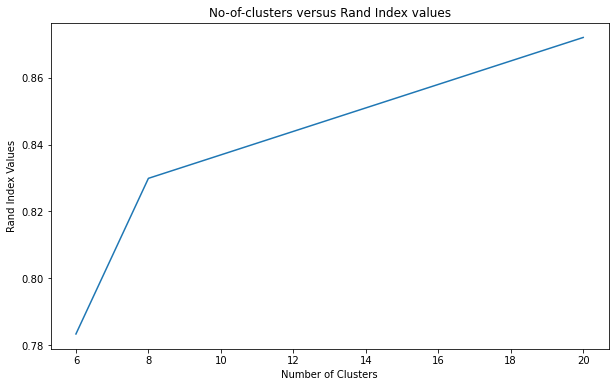

In [11]:
plot_LDA_RI_scores(number_of_clusters,list_of_RI)

# Generating document embeddings using doc2vec

### Documents for Doc2Vec

In [12]:
tagged_data = get_tagged_data(data_lemmatized)

In [13]:
number_of_clusters = [6,8,20]

### Learning embeddings of length 20

In [14]:
# Get Documents as Vectors
vectors = get_d2v_vectors(20, data_lemmatized)

### Hierarchical clustering of document embeddings

In [15]:
Euclidean_RI, Cosine_RI = get_clusters_from_vectors(number_of_clusters)

In [16]:
Euclidean_RI

[0.06336338240967351, 0.08047837263251625, 0.5141497793645238]

In [17]:
Cosine_RI

[0.6824622645075308, 0.7684758724153599, 0.8238931963132828]

### Plotting the Graph of No-of-clusters versus Rand Index values

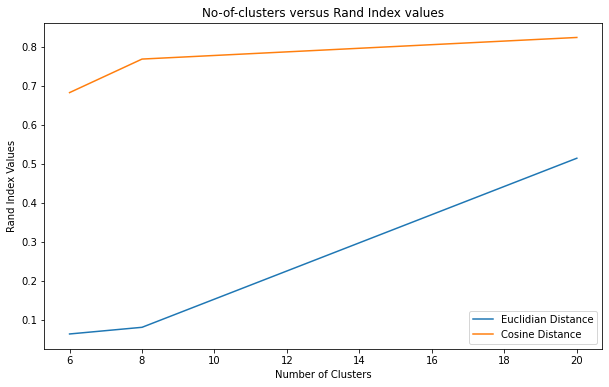

In [18]:
plot_d2v_clusters(number_of_clusters, Euclidean_RI, Cosine_RI)

### Learning 50 vectors

In [19]:
# Get Documents as Vectors
vectors = get_d2v_vectors(50, data_lemmatized)

In [20]:
Euclidean_RI, Cosine_RI = get_clusters_from_vectors(number_of_clusters)

In [21]:
Euclidean_RI

[0.07089744136037764, 0.07137914661573229, 0.13695596998645623]

In [22]:
Cosine_RI

[0.6890722268966133, 0.7038801789584713, 0.8640509733788468]

### Plotting the Graph of No-of-clusters versus Rand Index values

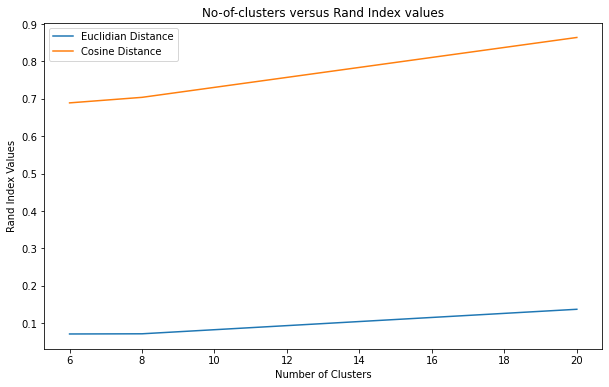

In [23]:
plot_d2v_clusters(number_of_clusters, Euclidean_RI, Cosine_RI)

### Learning 100 vectors

In [24]:
# Get Documents as Vectors
vectors = get_d2v_vectors(20, data_lemmatized)

In [25]:
Euclidean_RI, Cosine_RI = get_clusters_from_vectors(number_of_clusters)

In [26]:
Euclidean_RI

[0.06914507989442924, 0.10643626692427616, 0.5437965283751631]

In [27]:
Cosine_RI

[0.6875772499176962, 0.6942188697236512, 0.8559414244659425]

### Plotting the Graph of No-of-clusters versus Rand Index values

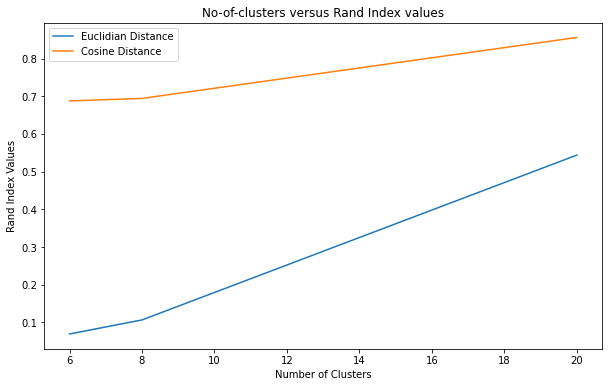

In [28]:
plot_d2v_clusters(number_of_clusters, Euclidean_RI, Cosine_RI)

#### As we can see the clusters generated from the LDA are more accurate with a Rand Index score of 0.87 which is a little higher as compared to the complete linkage cosine clustering in the 50 dimentional embedded space of documents. Hence we will move on to building the best model to get the documents clustered into their respective types.